In [1]:
import os, sys, warnings

import numpy  as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt

sns.set_context(context='poster')

import matplotlib as mpl
mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['font.sans-serif'] = "Arial"
mpl.rcParams['font.monospace'] = 'Andale Mono'
# mpl.rcParams['mathtext.fontset'] = 'stix'
mpl.rcParams['mathtext.rm'] = 'Arial'
mpl.rcParams['mathtext.default'] = 'rm'

mpl.rcParams['axes.linewidth'] = 1.5
mpl.rcParams['xtick.major.width'] = 1.5
mpl.rcParams['ytick.major.width'] = 1.5
mpl.rcParams['text.usetex'] = False
mpl.rcParams['text.latex.preamble'] = [
    r'\usepackage{wasysym}',
    r'\usepackage{amsmath}',
    r'\usepackage{amssymb}',
]

bigsize   = 20
midsize   = 20
smallsize = 15
hugesize  = 24

a4f = 2.5
width_a4f = 0.5
hight_a4f = 0.03

In [ ]:
sys.path.append('.'); warnings.simplefilter(action='ignore', category=FutureWarning);

from figdata import ref, xlsx_tab, ideo, good_df, sum_df, cell_chr_cnv_size, big_cnv_idx
from figdata import window, r_acen, chrf, bigCNV, big_cnv_cells
from figdata import color_dict, tf, bf, mf, rf

In [3]:
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

In [4]:
from scipy       import stats
from scipy.stats import gaussian_kde
from tqdm.auto   import tqdm
from glob        import glob

# Get Big CNVs

In [6]:
from matplotlib.path       import Path
from matplotlib.patches    import Polygon, PathPatch, Rectangle
from matplotlib.transforms import Affine2D

codes = [
    Path.MOVETO,
    Path.LINETO,
    Path.LINETO,
    Path.CURVE4,
    Path.CURVE4,
    Path.CURVE4,
    Path.CLOSEPOLY,
]

np.random.seed(0)

# Get data

In [7]:
max_alpha = 4
max_pie   = 40

In [8]:
good_cells = good_df.xs(key='copy',axis=1,level=1).columns

sample_code_dict = xlsx_tab.set_index('SAMPLE')['CODE'].to_dict()

chrom_dict = (ref.groupby('space').max()['end']//1e6).astype(int).to_dict()

two_colors = sns.xkcd_palette(['red', 'bright blue'])

def name2code(name):
    code = []
    for i in name.split('_'):
        if i in sample_code_dict:
            code.append(sample_code_dict[i])
        else:
            code.append(i)

    return '_'.join(code)

In [9]:
# cnv_frac_df = sum_df.set_index('Cell').loc[big_cnv_cells].reset_index()
# cnv_frac_df['chrom_fraction'] = (
#     100*cnv_frac_df['binSize']
#     /
#     cnv_frac_df['Space'].replace(
#         cell_chr_cnv_size['n_chr_bins']
#             .reset_index()
#             .drop_duplicates()
#             .set_index('Space')
#             .to_dict()['n_chr_bins']
#     )
# )
cnv_frac_df = sum_df.set_index('Cell').loc[big_cnv_cells].reset_index()

# Plot Function

In [10]:
def ideoPlot(chrom,ax):
    '''
    Plot ideo for one chromosome.
    '''
    tag_acen = 1
    chr_base = ref.groupby('space').min().loc[chrom,'abs_pos']
    rdis     = ref.groupby('space').max().loc[chrom,'end']*rf
    
    for idx, row in ideo.set_index('#chrom').loc[chrom].reset_index().iterrows():
        start    = row['chromStart'] + chr_base
        end      = row['chromEnd']   + chr_base
        gieStain = row['gieStain']

        if idx == 0:
            ax.set_xlim(start-rdis, ax.get_xlim()[1])
            v1 = [
                ( end,        tf ),
                ( end,        bf ),
                ( start,      bf ),
                ( start-rdis, bf ),
                ( start-rdis, tf ),
                ( start,      tf ),
                ( end,        tf ),
            ]
            p = PathPatch( Path(v1, codes), facecolor=color_dict[gieStain], edgecolor='black', lw=2, zorder=1 )
            ax.add_patch(p)
        elif idx == ideo.set_index('#chrom').loc[chrom].shape[0]-1:
            ax.set_xlim(ax.get_xlim()[0], end+rdis)
            v2 = [
                ( start,      bf ),
                ( start,      tf ),
                ( end,        tf ),
                ( end+rdis,   tf ),
                ( end+rdis,   bf ),
                ( end,        bf ),
                ( start,      bf ), 
            ]
            p = PathPatch( Path(v2, codes), facecolor=color_dict[gieStain], edgecolor='black', lw=2, zorder=1 )
            ax.add_patch(p)
        elif gieStain == 'acen':
            if tag_acen == 1:
                triangle = [
                    (start, bf),
                    (start, tf),
                    (end,   mf)
                ]
                tag_acen = 0
            elif tag_acen == 0:
                triangle = [
                    (end,   bf),
                    (end,   tf),
                    (start, mf)
                ]
                tag_acen = -1
            else:
                print ('Bug at acen!')
                continue
            p = Polygon( triangle, facecolor=color_dict[gieStain], edgecolor='black', lw=2, zorder=1 )
            ax.add_patch(p)
        else:
            p = Rectangle( (start,bf), end-start, height=(tf-bf), facecolor=color_dict[gieStain], edgecolor='black', lw=2, zorder=1 )
            ax.add_patch(p)
        
    ax.spines['top'   ].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['left'  ].set_visible(False)
    ax.spines['right' ].set_visible(False)

    ax.tick_params(bottom=False, length=2, pad=-20)
    ax.set_ylim(-4,1)
    ax.set_yticks([])
    
    chrom_bins = chrom_dict[chrom]
    boundary = max(2, chrom_bins//50)
    step = (chrom_bins+boundary)//5
    ideo_zero = ref.groupby('space').min().loc[chrom,'abs_pos']
    ax.set_xticks( 
         ideo_zero + np.arange( 0, (chrom_bins+boundary)+step, step )*1e6 
    )
    ax.set_xticklabels( 
        np.arange( 0, (chrom_bins+boundary)+step, step ),
        fontsize=midsize,
    )
    
    ax.set_xlim(ideo_zero-boundary*1e6,ideo_zero+(chrom_bins+boundary)*1e6)
    
    return ax

In [12]:
# https://nasseralkmim.github.io/notes/2016/03/05/reusingaxes/

# x = np.linspace(0, 2*np.pi, 400)
# y = np.sin(x**2)
# y2 = np.cos(x**2)

# fig1 = plt.figure('fig1')
# ax1 = fig1.add_subplot(1, 1, 1)
# ax1.plot(x, y)
# plt.tight_layout()

# fig2 = plt.figure('fig2')
# ax2 = fig2.add_subplot(111)
# ax2.plot(x, y2, 'g')
# plt.tight_layout()

# fig3 = plt.figure('fig3')
# ax1.change_geometry(2, 1, 1)
# ax2.change_geometry(2, 1, 2)
# fig3._axstack.add(fig3._make_key(ax1), ax1)
# fig3._axstack.add(fig3._make_key(ax2), ax2)
# plt.tight_layout()

In [13]:
def cell_plot(snp_df,cell,chrom,ax1,ax2):

    chrom_bins = chrom_dict[chrom]
    boundary = max(2, chrom_bins//50)
    
    cell_df = snp_df[cell].dropna()

    fig_df = pd.concat(
        [
            cell_df,
            good_df[cell],
            ref.loc[cell_df.index],
        ], axis=1, sort=False
    ).query('space==@chrom')

    dot_df = pd.concat(
        [
            ref,
            good_df[cell,'copy'].dropna().rename('copy'),
#                 data_df[cell,'copy'].dropna().rename('copy'),
        ], axis=1, sort=False
    ).query('space==@chrom').dropna()

    ax1.plot( dot_df['start']/1e6, dot_df['copy'], '.', alpha=0.7, color='k', ms=3, zorder=3 )

    y = fig_df[['CBSseg','HMMseg']].fillna(2).mean().round().mean()
    for idx,row in fig_df.iterrows():
        x = row['start']/1e6
#             y = 2
        if cell == 'XXX':
            ym = row[['CBSseg','HMMseg']].dropna().mean()
            if np.isnan(ym):
                y = 1
            else:
                y = round(ym)

        a = min(0.8, row['A']/max_alpha)
        b = min(0.8, row['B']/max_alpha)
        ax1.scatter(x, y, s=75, alpha=a, color=two_colors[0], zorder=2)
        ax1.scatter(x, y, s=75, alpha=b, color=two_colors[1], zorder=2)

    ax1.set_ylim(-0.5,3.5)
    ax1.spines['top'   ].set_visible(False)
    ax1.spines['bottom'].set_visible(False)

    ax1.set_xticks([])
    ax1.set_yticks([0,1,2,3])
    ax1.tick_params(axis='y', labelsize=smallsize-4, length=5, rotation=90, pad=2)

    ax1.set_ylabel(
        name2code(cell),
        rotation=0, fontsize=smallsize, ha='right', va='center'
    )

    ax2.set_ylabel(
        'SNPs: '+str(int(fig_df.sum()['n'])),
        rotation=0, fontsize=smallsize, 
        ha='left', va='center',
        labelpad=50
    )
    ax2.yaxis.set_label_position('right')

    piz = fig_df.sum()['n']/max_pie
    if piz >= 2:
        piz = 1.5
    else:
        piz = np.sqrt(piz)

    ax2.pie( 
        fig_df.sum()[['A','B','E']].tolist(), 
        colors=[two_colors[0],two_colors[1],'gray'],
        radius=piz
    )

    ax1.set_xlim(-boundary,chrom_bins+boundary)
    ax1.hlines(0,-boundary,chrom_bins+boundary, lw=0.7, linestyle='dashed', zorder=0 )
    ax1.hlines(1,-boundary,chrom_bins+boundary, lw=0.7, linestyle='dashed', zorder=0 )
    ax1.hlines(2,-boundary,chrom_bins+boundary, lw=1.5, linestyle='dashed', zorder=0 )
    ax1.hlines(3,-boundary,chrom_bins+boundary, lw=0.7, linestyle='dashed', zorder=0 )

    return fig_df

In [14]:
def plot_chrom_SNP(sample, chrom):
    
    pie_df = []
    
    snp_df = pd.read_pickle(sample+'.bin_snp.' + window + '.pkl').dropna(how='all', axis=0)
    clean_cells = (
        set( 
            good_cells[good_cells.str.contains(sample)].to_list() 
        ) 
        - 
        set( 
            sum_df.query('Sample==@sample')['Cell'].unique().tolist() 
        )
    )
    
    add_n_cells = 2
    add_list = []
    
    if (sample == 'XXX') and (chrom == 'chr10'):
        add_n_cells = 3 
        add_list = ['XXX']

    chrom_cells = cnv_frac_df.query('Space==@chrom & cnvTag=="Loss" & chrom_fraction>=95 & Sample==@sample')['Cell'].unique()
    
    fig, axs = plt.subplots(
        nrows=chrom_cells.shape[0]+add_n_cells, ncols=2, 
#         figsize=(12,chrom_cells.shape[0]+add_n_cells),
        figsize=(a4f*width_a4f*8.27,a4f*hight_a4f*11.69*(chrom_cells.shape[0]+add_n_cells)),

        gridspec_kw={
            'width_ratios': [11, 1],
            'hspace': 0.15,
            'wspace': 0.05,
        },
    )

    for n, cell in enumerate( chrom_cells.tolist() + add_list + [np.random.choice( list(clean_cells) ).tolist()] ):
        fig_df = cell_plot(snp_df,cell,chrom,axs[n,0],axs[n,1])
        pie_df.append(fig_df.sum()[['A','B','E']].rename(cell))

    axs[0,0].set_title(sample_code_dict[sample] + ' ' + chrom + ' loss', fontsize=hugesize)
    
    axs[-1,0].set_xlabel(chrom+' position (Mb)', fontsize=bigsize)
    
#     ideo_zero = ref.groupby('space').min().loc[chrom,'abs_pos']
#     axs[-1,0].set_xticks( 
#          ideo_zero + np.arange( 0, (chrom_bins+boundary)+step, step )*1e6 
#     )
#     axs[-1,0].set_xticklabels( 
#         np.arange( 0, (chrom_bins+boundary)+step, step ),
#         fontsize=midsize,
#     )
    
#     axs[-1,0].set_xlim(ideo_zero-boundary*1e6,ideo_zero+(chrom_bins+boundary)*1e6)
#     axs[-1,0].tick_params(bottom=False, length=2, pad=-30)
#     axs[-1,0].set_ylim(-4,1)
#     axs[-1,0].set_yticks([])
#     axs[-1,0].spines['top'   ].set_visible(False)
#     axs[-1,0].spines['bottom'].set_visible(False)
#     axs[-1,0].spines['left'  ].set_visible(False)
#     axs[-1,0].spines['right' ].set_visible(False)
    
    ideoPlot(chrom,axs[-1,0])
    
    axs[-1,1].axis('off')

    pie_df = pd.concat(pie_df[:-1], axis=1).T.astype(int)
    pie_df['pA'] = pie_df.apply(lambda row: stats.binom_test( [row['A'], row['B']], alternative='greater')<0.001, axis=1 )
    pie_df['pB'] = pie_df.apply(lambda row: stats.binom_test( [row['B'], row['A']], alternative='greater')<0.001, axis=1 )

    assert (pie_df[['pA','pB']].sum(axis=1)==2).sum() == 0

#     return None
    return fig, pie_df

---
---
---

# Plot

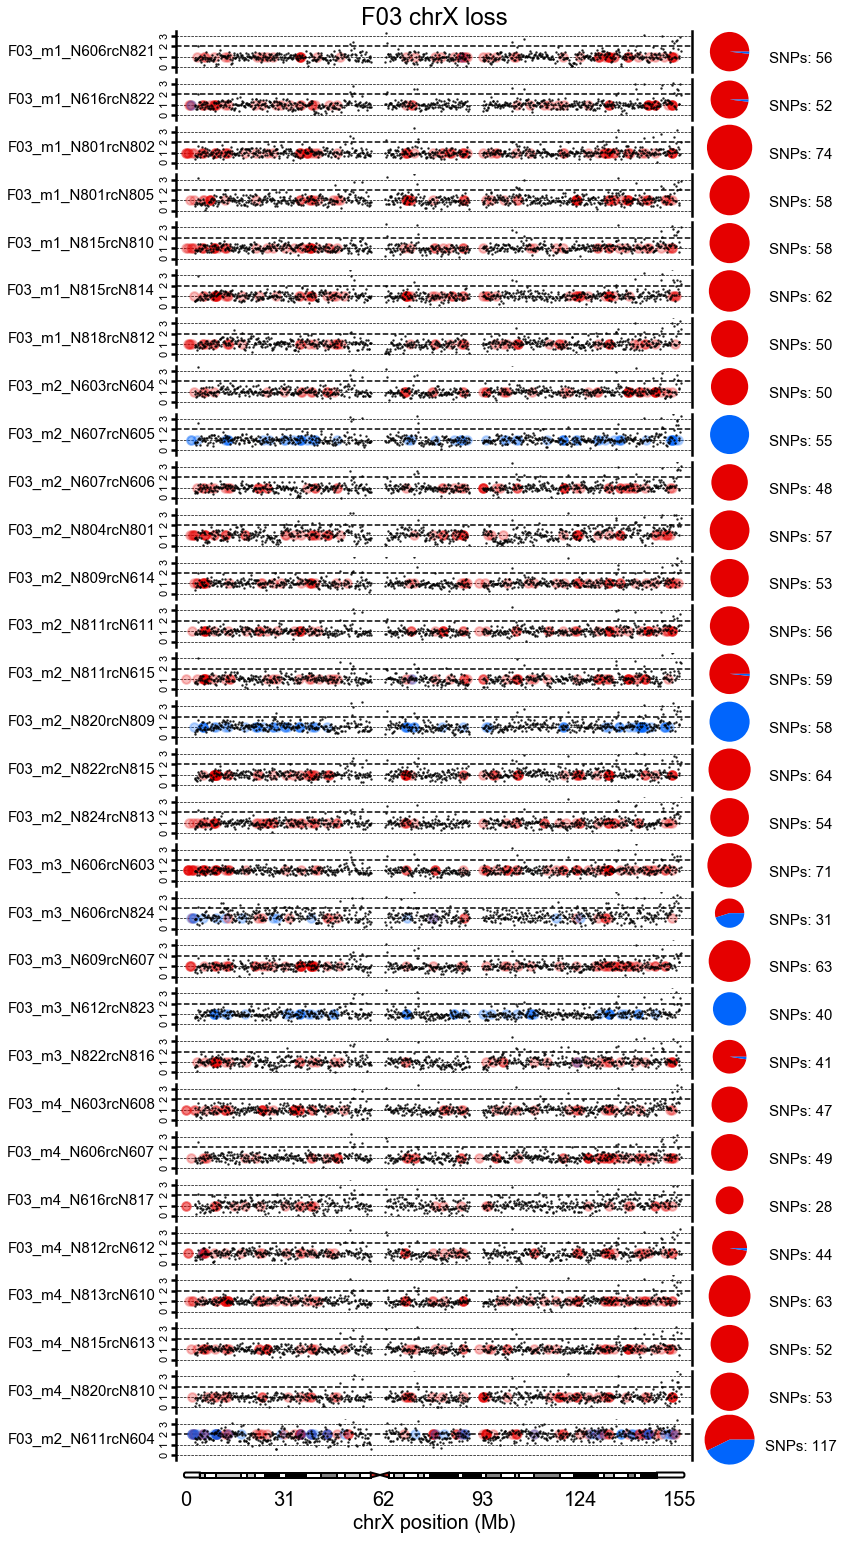

In [15]:
f, XXX_pie_df = plot_chrom_SNP('XXX', 'chrX')
f.savefig('XXX_chrX.pdf', frameon=False, transparent=True, bbox_inches='tight')

n_false  = (XXX_pie_df[['pA','pB']].sum(axis=1)==0).sum()
n_A_loss = XXX_pie_df['pA'].sum()
n_B_loss = XXX_pie_df['pB'].sum()
XXX_s = pd.Series({'M':n_A_loss,'P':n_B_loss, 'E':n_false}).rename('XXX')

---

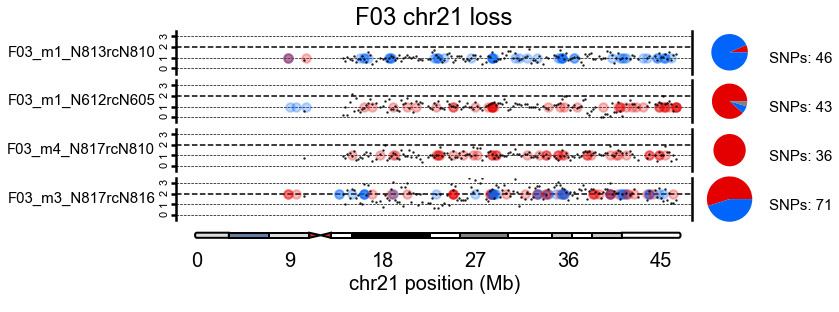

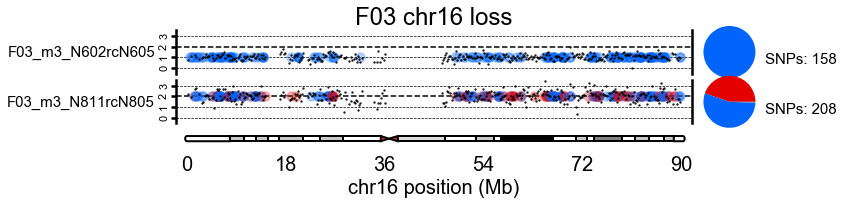

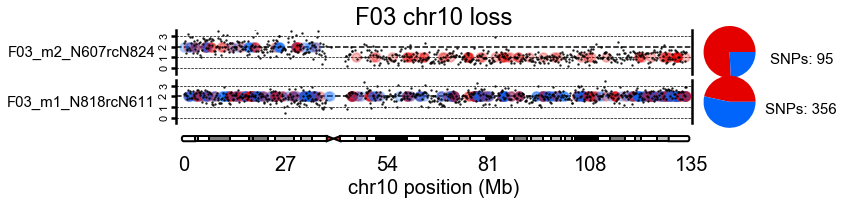

In [16]:
for chrom in cnv_frac_df.query('Space!="chrX" & cnvTag=="Loss" & chrom_fraction>=95 & Sample=="XXX"')['Space'].unique().tolist() + ['chr10']:
    f,_ = plot_chrom_SNP('XXX', chrom)
    f.savefig('XXX_' + chrom + '.pdf', frameon=False, transparent=True, bbox_inches='tight')

---
---
---

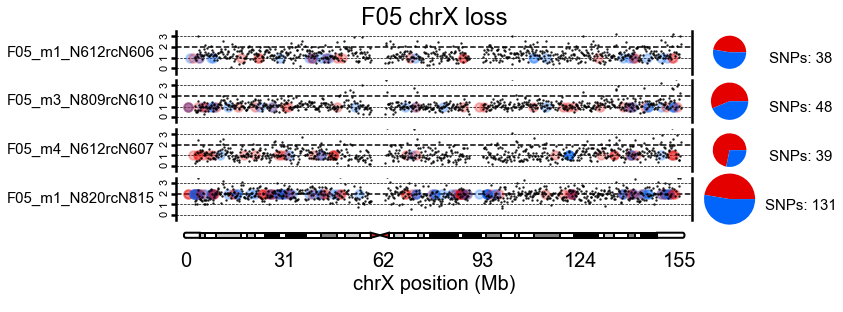

In [17]:
f,_ = plot_chrom_SNP('XXX', 'chrX')

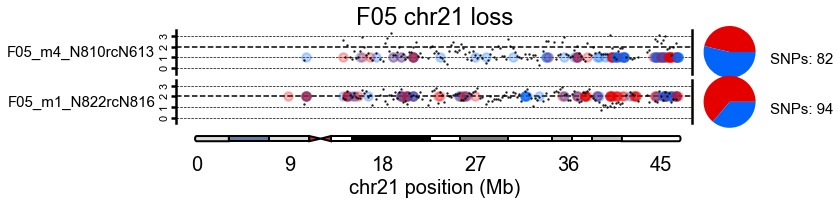

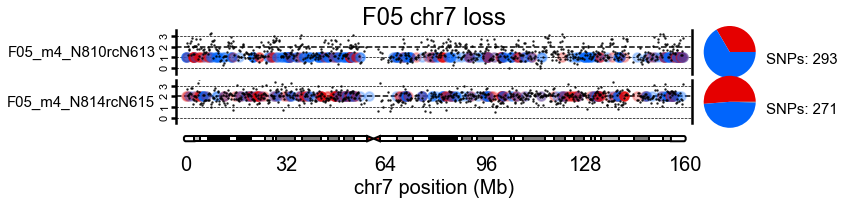

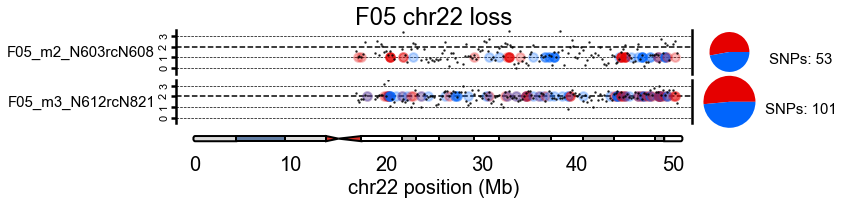

In [18]:
for chrom in cnv_frac_df.query('Space!="chrX" & cnvTag=="Loss" & chrom_fraction>=95 & Sample=="XXX"')['Space'].unique():
    f,_ = plot_chrom_SNP('XXX', chrom)

---
---
---

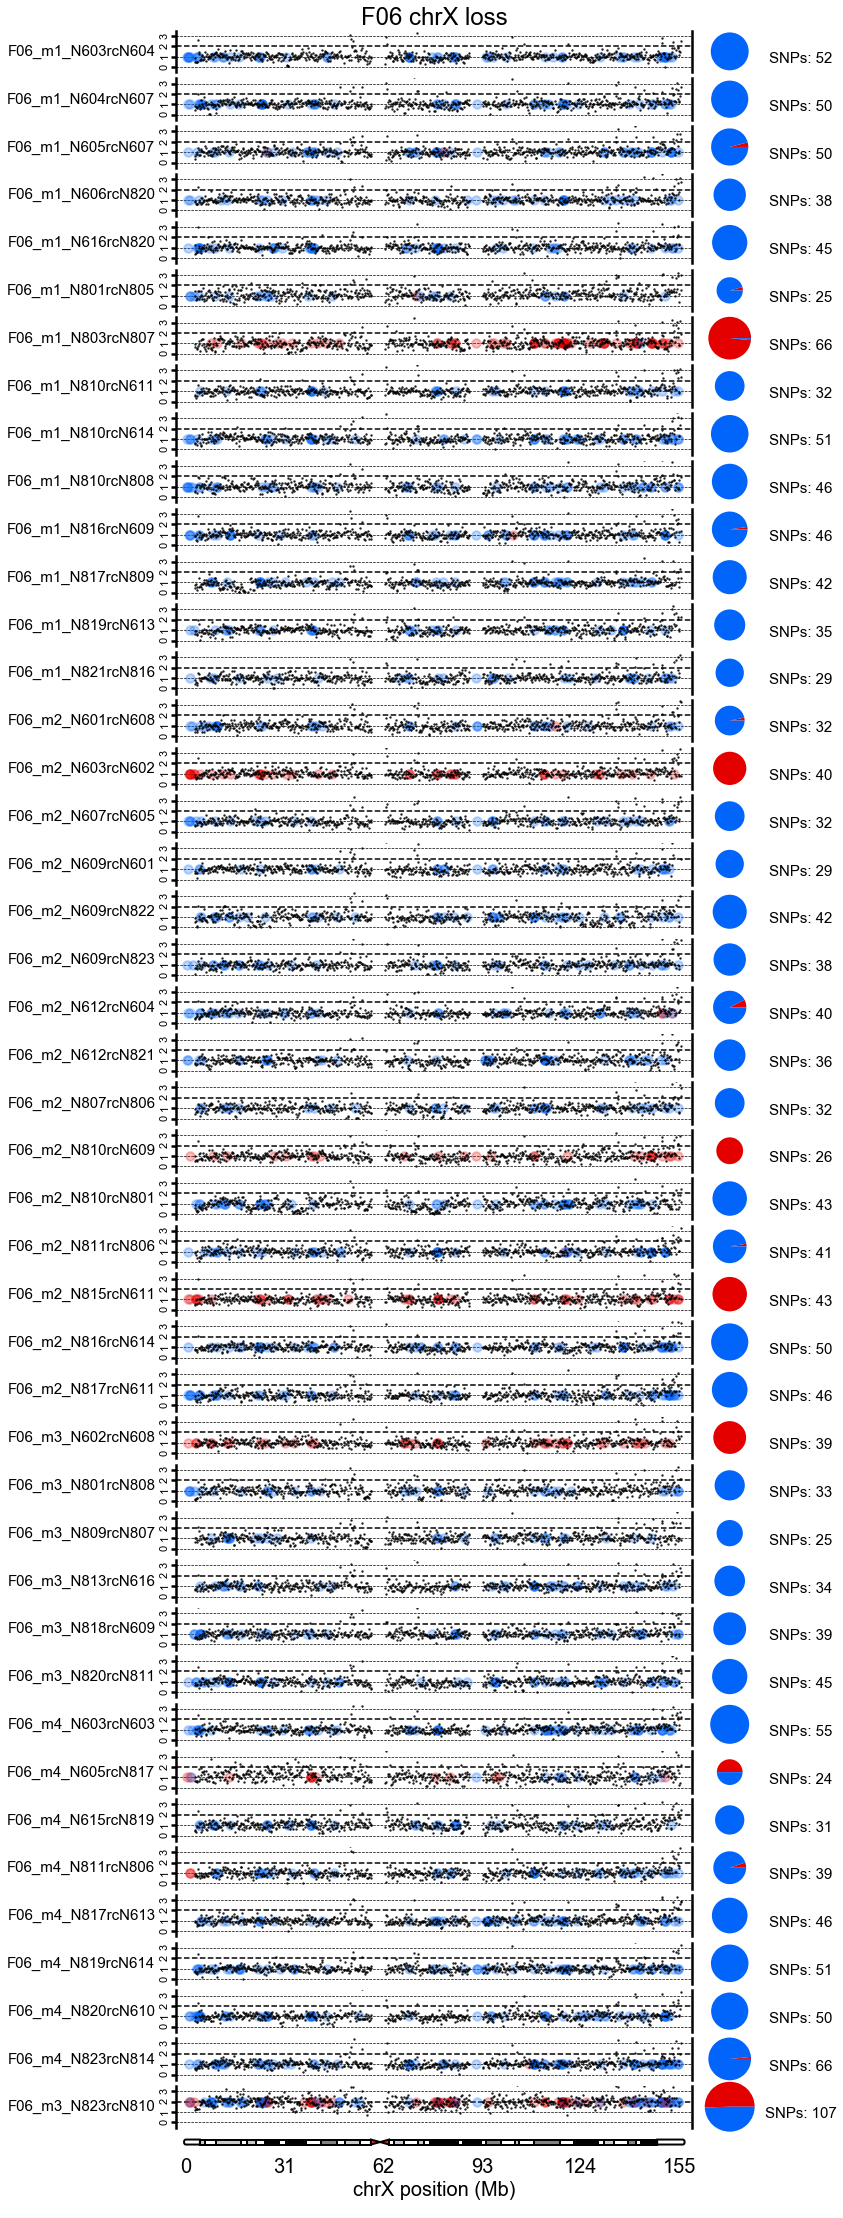

In [19]:
f, XXX_pie_df = plot_chrom_SNP('XXX', 'chrX')
f.savefig('XXX_chrX.pdf', frameon=False, transparent=True, bbox_inches='tight')

n_false  = (XXX_pie_df[['pA','pB']].sum(axis=1)==0).sum()
n_A_loss = XXX_pie_df['pA'].sum()
n_B_loss = XXX_pie_df['pB'].sum()
XXX_s = pd.Series({'M':n_A_loss,'P':n_B_loss, 'E':n_false}).rename('XXX')

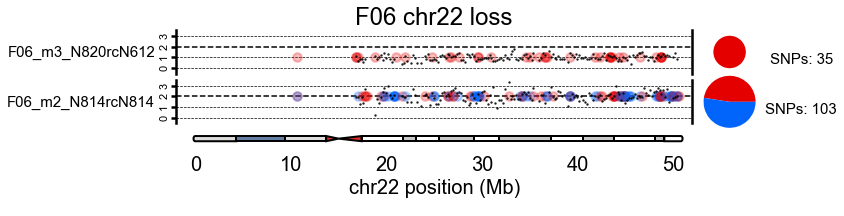

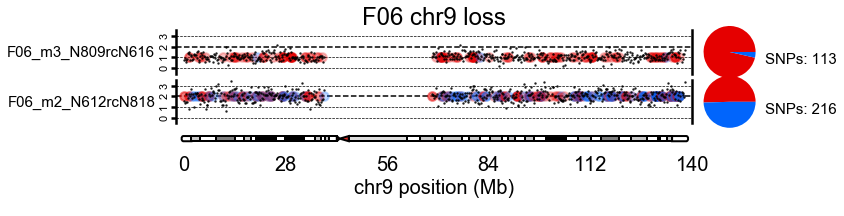

In [20]:
for chrom in cnv_frac_df.query('Space!="chrX" & cnvTag=="Loss" & chrom_fraction>=95 & Sample=="XXX"')['Space'].unique():
    f,_ = plot_chrom_SNP('XXX', chrom)
    f.savefig('XXX_' + chrom + '.pdf', frameon=False, transparent=True, bbox_inches='tight')    

---
---
---

In [21]:
def autolabel(rects):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = rect.get_height()
        ax.annotate(
            '{:d}'.format(height),
            xy=(rect.get_x() + rect.get_width() / 2, height),
            xytext=(0, 3),  # 3 points vertical offset
            textcoords="offset points",
            fontsize=smallsize,
            ha='center', va='bottom'
        )

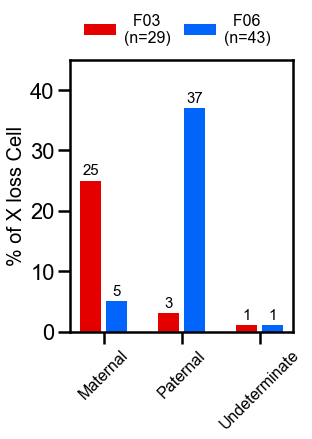

In [22]:
XXX_s_p = 100 * XXX_s/XXX_s.sum()
XXX_s_p   = 100 *  XXX_s/XXX_s.sum()

fig, ax = plt.subplots(figsize=(4,5))

rects1 = ax.bar(0, XXX_s['M'], color=two_colors[0], label='  F03\n(n=' + str(XXX_s.sum()) + ')')
rects2 = ax.bar(1,   XXX_s['M'], color=two_colors[1], label='  F06\n(n=' + str(XXX_s.sum())   + ')')

rects3 = ax.bar(3, XXX_s['P'], color=two_colors[0])
rects4 = ax.bar(4,   XXX_s['P'], color=two_colors[1])

rects5 = ax.bar(6, XXX_s['E'], color=two_colors[0], zorder=0)
rects6 = ax.bar(7,   XXX_s['E'], color=two_colors[1], zorder=0)

ax.set_ylim(0,45)
ax.set_xticks([0.5,3.5,6.5])
ax.set_xticklabels(['Maternal','Paternal','Undeterminate'], rotation=45, fontsize=16)
# ax.set_xlabel('chrX', fontsize=20)
ax.set_ylabel('% of X loss Cell', fontsize=20)

ax.legend(
    loc='lower left', bbox_to_anchor=(0, 1), ncol=2, 
    prop={'size':16}, 
    columnspacing=0.8, handletextpad=0.5,
    frameon=False,
)

autolabel(rects1)
autolabel(rects2)
autolabel(rects3)
autolabel(rects4)
autolabel(rects5)
autolabel(rects6)

plt.show()

In [23]:
# width_a4f = 0.25
# hight_a4f = 0.2

# fig, (ax1, ax2) = plt.subplots(
#     ncols=1, nrows=2, 
#     figsize=(
#         a4f*width_a4f*8.27,
#         a4f*hight_a4f*11.69
#     )
# )

# lg1, _, t1 = ax1.pie( 
#     XXX_s_p.tolist(),
#     colors=[two_colors[0],two_colors[1],'gray'],
#     autopct='%1.1f%%',
#     textprops={'size':smallsize,'ha':'center','va':'center'},
#     pctdistance=0.5
# )

# t1[1].set_text(4*' '+t1[1].get_text())
# t1[2].set_text(4*' '+t1[2].get_text())
# t1[1].set_fontsize(smallsize-4)
# t1[2].set_fontsize(smallsize-4)

# _,_,t2 = ax2.pie( 
#     XXX_s_p.tolist(), 
#     colors=[two_colors[0],two_colors[1],'gray'],
#     autopct='%1.1f%%',
#     textprops={'size':smallsize,'ha':'center','va':'center'},
#     pctdistance=0.5
# )

# t2[0].set_text(4*' '+t2[0].get_text())
# t2[2].set_text(4*' '+t2[2].get_text())
# t2[0].set_fontsize(smallsize-4)
# t2[2].set_fontsize(smallsize-4)

# ax1.set_title(xlsx_tab.set_index('SAMPLE').loc['XXX','CODE'],fontsize=bigsize)
# ax2.set_title(xlsx_tab.set_index('SAMPLE').loc['XXX',  'CODE'],fontsize=bigsize)

# ax2.legend(
#     lg1, 
#     (['Maternal X','Paternal X','Undeterminate']), 
#     loc='center',
#     bbox_to_anchor=(0.6, -0.3),
#     prop={'size':smallsize},
#     columnspacing=0.8, handletextpad=0.5,
#     frameon=False,
# )

# plt.show()

In [24]:
def pie_plot(data1, data2, ax1, ax2):
    lg1, _, t1 = ax1.pie( 
        data1.tolist(),
        colors=[two_colors[0],two_colors[1],'gray'],
        autopct='%1.1f%%',
        textprops={'size':smallsize,'ha':'center','va':'center'},
        pctdistance=0.5
    )

    t1[1].set_text(4*' '+t1[1].get_text())
    t1[2].set_text(4*' '+t1[2].get_text())
    t1[1].set_fontsize(smallsize)
    t1[2].set_fontsize(smallsize)

    _,_,t2 = ax2.pie( 
        data2.tolist(), 
        colors=[two_colors[0],two_colors[1],'gray'],
        autopct='%1.1f%%',
        textprops={'size':smallsize,'ha':'center','va':'center'},
        pctdistance=0.5
    )

    t2[0].set_text(4*' '+t2[0].get_text())
    t2[2].set_text(4*' '+t2[2].get_text())
    t2[0].set_fontsize(smallsize)
    t2[2].set_fontsize(smallsize)

    ax2.legend(
        lg1, 
        (['Maternal X','Paternal X','Undeterminate']), 
        loc='center',
        bbox_to_anchor=(0.6, -0.3),
        prop={'size':smallsize},
        columnspacing=0.8, handletextpad=0.5,
        frameon=False,
    )

    return

In [25]:
# width_a4f = 0.25
# hight_a4f = 0.2

# fig, (ax1, ax2) = plt.subplots(
#     ncols=1, nrows=2, 
#     figsize=(
#         a4f*width_a4f*8.27,
#         a4f*hight_a4f*11.69
#     )
# )

# pie_plot(XXX_s_p, XXX_s_p, ax1, ax2)
# ax1.set_title(xlsx_tab.set_index('SAMPLE').loc['XXX','CODE'],fontsize=bigsize)
# ax2.set_title(xlsx_tab.set_index('SAMPLE').loc['XXX',  'CODE'],fontsize=bigsize)
# plt.show()

---
---
---

In [26]:
def demo_ideo(ax):
    ideoPlot('chr20',ax)
    r = Affine2D().rotate_deg(90) + ax.transData
    
    for x in ax.patches:
        x.set_transform(r)
        
    y1,y2 = ax.get_ylim()
    x1,x2 = ax.get_xlim()

    ax.set_xlim(y1,y2)
    ax.set_ylim(x2,x1)
    
    return None

In [27]:
XXX_snp_df = pd.read_pickle('XXX.bin_snp.200k.pkl').dropna(how='all', axis=0)
XXX_snp_df   = pd.read_pickle('XXX.bin_snp.200k.pkl').dropna(how='all', axis=0)

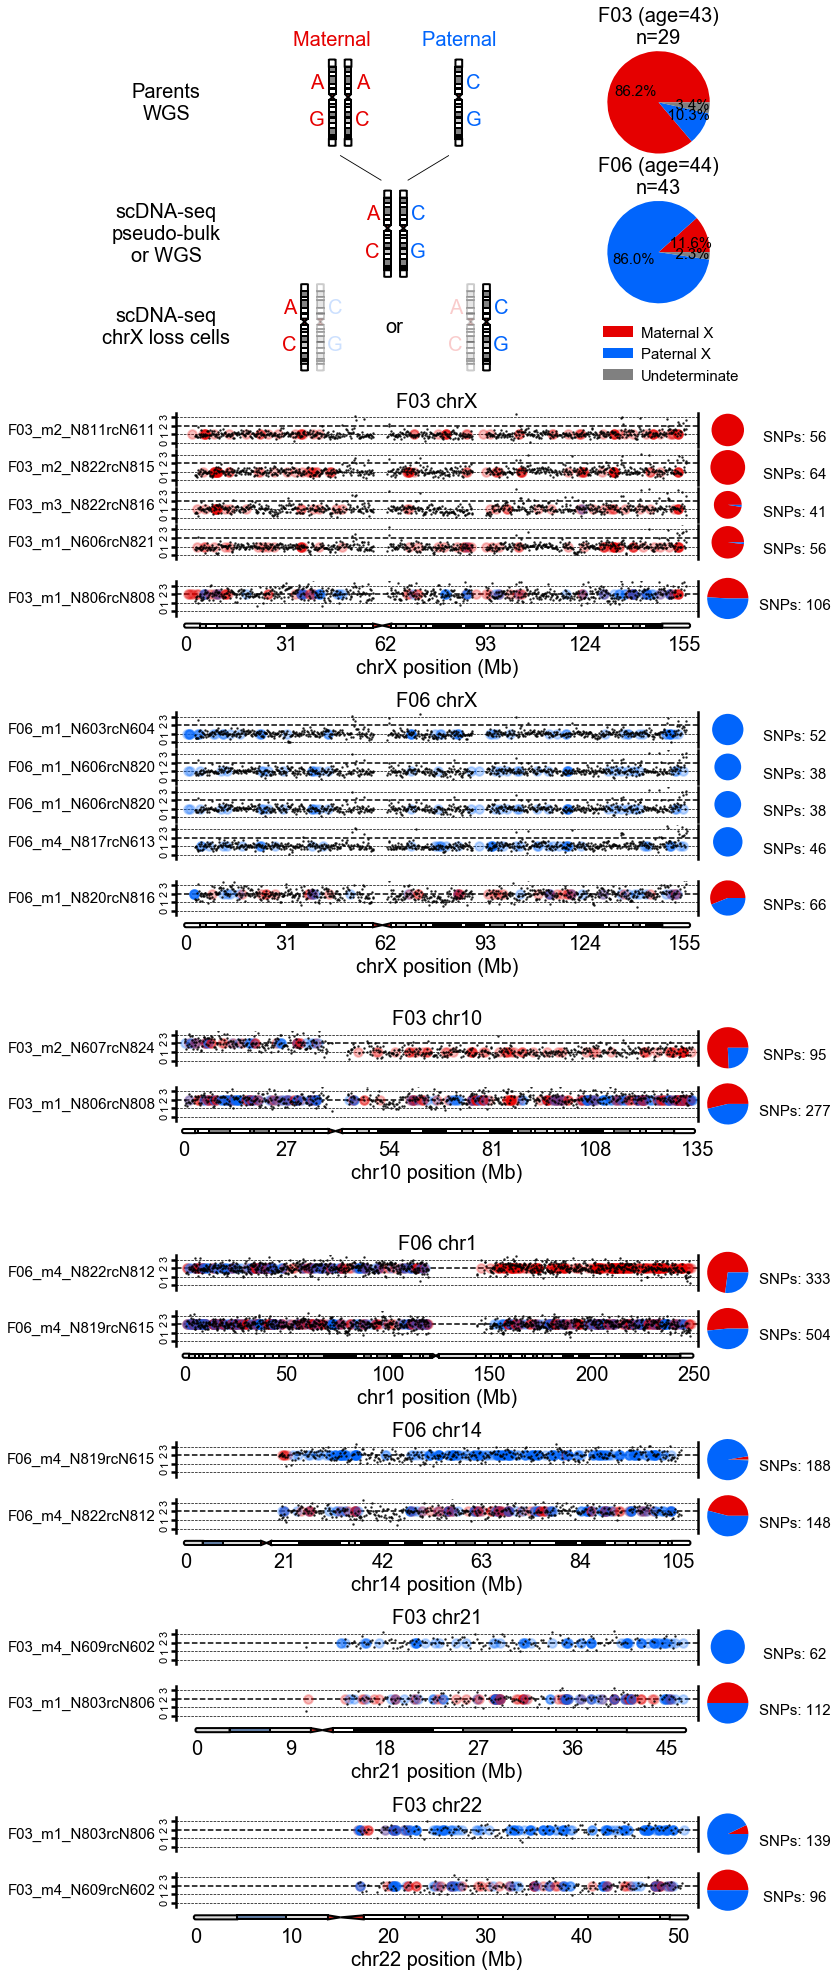

In [28]:
# hight_a4f = 0.6
# width_a4f = 0.5

hight_a4f = 1.2
width_a4f = 0.5

x1 = -6.5
x2 = 0.5

x3 = -0.5
x4 = 6.5

pos1 = 2712*1e6 + 20*1e6
pos2 = 2780*1e6 - 20*1e6

fig = plt.figure(figsize=(a4f*width_a4f*8.27,a4f*hight_a4f*11.69))
# gs  = mpl.gridspec.GridSpec(nrows=42, ncols=21, figure=fig)
# gs  = mpl.gridspec.GridSpec(nrows=84, ncols=21, figure=fig)
# gs  = mpl.gridspec.GridSpec(nrows=84, ncols=42, figure=fig)
# gs  = mpl.gridspec.GridSpec(nrows=50, ncols=21, figure=fig)
gs  = mpl.gridspec.GridSpec(nrows=102, ncols=21, figure=fig)

ax0_1y = fig.add_subplot( gs[ 1:6,  0:2 ] )
for i in ax0_1y.spines:
    ax0_1y.spines[i].set_visible(False)
ax0_1y.set_xticks([])
ax0_1y.set_yticks([])
ax0_1y.set_ylabel('Parents\nWGS', fontsize=midsize, ha='center', va='center', rotation=0, labelpad=10)
    
ax0_1a = fig.add_subplot( gs[ 1:6,  3:6 ] )
ax0_1b = fig.add_subplot( gs[ 1:6,  6:9 ] )
ax0_1c = fig.add_subplot( gs[ 1:6,  10:13 ] )

demo_ideo(ax0_1a)
demo_ideo(ax0_1b)
ax0_1a.set_xlim(x1,x2)
ax0_1b.set_xlim(x3,x4)
ax0_1a.set_title(' '*12 + 'Maternal\n', ha='center', va='center', fontsize=midsize, color=two_colors[0])
ax0_1c.set_title('Paternal' + ' '*12 + '\n', ha='center', va='center', fontsize=midsize, color=two_colors[1])

demo_ideo(ax0_1c)
ax0_1c.set_xlim(x3,x4)

ax0_1a.text(-1.35, pos1,'A', ha='center', va='center', fontsize=midsize, color=two_colors[0])
ax0_1a.text(-1.35, pos2,'G', ha='center', va='center', fontsize=midsize, color=two_colors[0])
ax0_1b.text( 1.30, pos1,'A', ha='center', va='center', fontsize=midsize, color=two_colors[0])
ax0_1b.text( 1.30, pos2,'C', ha='center', va='center', fontsize=midsize, color=two_colors[0])
ax0_1c.text( 1.30, pos1,'C', ha='center', va='center', fontsize=midsize, color=two_colors[1])
ax0_1c.text( 1.30, pos2,'G', ha='center', va='center', fontsize=midsize, color=two_colors[1])

############################################################

axl_01 = fig.add_subplot( gs[ 6:8,  3:10 ] )
axl_01.plot([6.0, 7.5], [1,0],'-',color='k',lw=0.85)
axl_01.plot([8.5, 10.], [0,1],'-',color='k',lw=0.85)
axl_01.axis('off')
axl_01.set_xlim(3,10)
axl_01.set_ylim(-0.2,1.2)

############################################################

ax0_2y = fig.add_subplot( gs[ 8:13,  0:2 ] )
for i in ax0_2y.spines:
    ax0_2y.spines[i].set_visible(False)
ax0_2y.set_xticks([])
ax0_2y.set_yticks([])
ax0_2y.set_ylabel('scDNA-seq\npseudo-bulk\nor WGS', fontsize=midsize, ha='center', va='center', rotation=0, labelpad=10)

ax0_2a = fig.add_subplot( gs[ 8:13,  5:8 ] )
ax0_2b = fig.add_subplot( gs[ 8:13,  8:11 ] )
demo_ideo(ax0_2a)
demo_ideo(ax0_2b)
ax0_2a.set_xlim(x1,x2)
ax0_2b.set_xlim(x3,x4)

ax0_2a.text(-1.35, pos1,'A', ha='center', va='center', fontsize=midsize, color=two_colors[0])
ax0_2a.text(-1.35, pos2,'C', ha='center', va='center', fontsize=midsize, color=two_colors[0])
ax0_2b.text( 1.30, pos1,'C', ha='center', va='center', fontsize=midsize, color=two_colors[1])
ax0_2b.text( 1.30, pos2,'G', ha='center', va='center', fontsize=midsize, color=two_colors[1])

############################################################

ax0_3y = fig.add_subplot( gs[ 13:18,  0:2 ] )
for i in ax0_3y.spines:
    ax0_3y.spines[i].set_visible(False)
ax0_3y.set_xticks([])
ax0_3y.set_yticks([])
ax0_3y.set_ylabel('scDNA-seq\nchrX loss cells', fontsize=midsize, ha='center', va='center', rotation=0, labelpad=10)

ax0_3a = fig.add_subplot( gs[ 13:18,  2:5 ] )
ax0_3b = fig.add_subplot( gs[ 13:18,  5:8 ] )
demo_ideo(ax0_3a)
demo_ideo(ax0_3b)
ax0_3a.set_xlim(x1,x2)
ax0_3b.set_xlim(x3,x4)

for i in ax0_3b.patches:
    i.set_alpha(0.2)

ax0_3c = fig.add_subplot( gs[ 13:18,  8:11 ] )
ax0_3d = fig.add_subplot( gs[ 13:18,  11:14 ] )
demo_ideo(ax0_3c)
demo_ideo(ax0_3d)
ax0_3c.set_xlim(x1,x2)
ax0_3d.set_xlim(x3,x4)
                        
for i in ax0_3c.patches:
    i.set_alpha(0.2)

ax0_3c.set_ylabel('or', fontsize=bigsize, ha='center', va='center', rotation=0)

ax0_3a.text(-1.35, pos1,'A', ha='center', va='center', fontsize=midsize, color=two_colors[0])
ax0_3a.text(-1.35, pos2,'C', ha='center', va='center', fontsize=midsize, color=two_colors[0])
ax0_3b.text( 1.30, pos1,'C', ha='center', va='center', fontsize=midsize, color=two_colors[1], alpha=0.2)
ax0_3b.text( 1.30, pos2,'G', ha='center', va='center', fontsize=midsize, color=two_colors[1], alpha=0.2)

ax0_3c.text(-1.35, pos1,'A', ha='center', va='center', fontsize=midsize, color=two_colors[0], alpha=0.2)
ax0_3c.text(-1.35, pos2,'C', ha='center', va='center', fontsize=midsize, color=two_colors[0], alpha=0.2)
ax0_3d.text( 1.30, pos1,'C', ha='center', va='center', fontsize=midsize, color=two_colors[1])
ax0_3d.text( 1.30, pos2,'G', ha='center', va='center', fontsize=midsize, color=two_colors[1])

############################################################

ax1 = fig.add_subplot( gs[ 0:7,  14:21  ] )
ax2 = fig.add_subplot( gs[ 8:15, 14:21  ] )

pie_plot(XXX_s_p, XXX_s_p, ax1, ax2)
ax1.set_title('{} (age={:0.0f})\nn={}'.format(
    xlsx_tab.set_index('SAMPLE').loc['XXX','CODE'], xlsx_tab.set_index('SAMPLE').loc['XXX','AGE'], XXX_s.sum(), 
), fontsize=bigsize, pad=-5)
ax2.set_title('{} (age={:0.0f})\nn={}'.format(
    xlsx_tab.set_index('SAMPLE').loc['XXX',  'CODE'], xlsx_tab.set_index('SAMPLE').loc['XXX',  'AGE'], XXX_s.sum(),
),   fontsize=bigsize, pad=-5)

############################################################

s_idx = 20
tag = True
np.random.seed(0)
for n, cell in enumerate(
    np.random.choice( 
        cnv_frac_df.query('Space=="chrX" & cnvTag=="Loss" & chrom_fraction>=95 & Sample=="XXX"')['Cell'].unique(),
        4,
    )
):
    ax_c1 = fig.add_subplot( gs[ s_idx+2*n:s_idx+2*n+2,  :19  ] )
    ax_c2 = fig.add_subplot( gs[ s_idx+2*n:s_idx+2*n+2,  19:21  ] )
    _ = cell_plot(XXX_snp_df, cell, 'chrX', ax_c1, ax_c2)
    if tag:
        ax_c1.set_title(sample_code_dict['XXX'] + ' chrX', fontsize=bigsize)
        tag = False

s_idx = s_idx+2*n+3
ax_c1 = fig.add_subplot( gs[ s_idx:s_idx+2,  :19  ] )
ax_c2 = fig.add_subplot( gs[ s_idx:s_idx+2,  19:21  ] )
_ = cell_plot(XXX_snp_df, 'XXX_m1_N806rcN808', 'chrX', ax_c1, ax_c2) 

s_idx = s_idx+2
ax_ideo_chrX = fig.add_subplot( gs[ s_idx:s_idx+2,  :19  ] )
ideoPlot('chrX', ax_ideo_chrX)
ax_ideo_chrX.set_xlabel('chrX position (Mb)', fontsize=bigsize)

############################################################

s_idx = s_idx+5
tag = True
np.random.seed(0)
for n, cell in enumerate(
    np.random.choice( 
        cnv_frac_df.query('Space=="chrX" & cnvTag=="Loss" & chrom_fraction>=95 & Sample=="XXX"')['Cell'].unique(),
        4,
    )
):
    ax_c1 = fig.add_subplot( gs[ s_idx+2*n:s_idx+2*n+2,  :19  ] )
    ax_c2 = fig.add_subplot( gs[ s_idx+2*n:s_idx+2*n+2,  19:21  ] )
    _ = cell_plot(XXX_snp_df, cell, 'chrX', ax_c1, ax_c2)
    if tag:
        ax_c1.set_title(sample_code_dict['XXX'] + ' chrX', fontsize=bigsize)
        tag = False

s_idx = s_idx+2*n+3
ax_c1 = fig.add_subplot( gs[ s_idx:s_idx+2,  :19  ] )
ax_c2 = fig.add_subplot( gs[ s_idx:s_idx+2,  19:21  ] )
_ = cell_plot(XXX_snp_df, 'XXX_m1_N820rcN816', 'chrX', ax_c1, ax_c2) 

s_idx = s_idx+2
ax_ideo_chrX = fig.add_subplot( gs[ s_idx:s_idx+2,  :19  ] )
ideoPlot('chrX', ax_ideo_chrX)
ax_ideo_chrX.set_xlabel('chrX position (Mb)', fontsize=bigsize)

############################################################
############################################################
############################################################

tag = True
s_idx = s_idx+2+2
for cell in [ 'XXX_m2_N607rcN824', 'XXX_m1_N806rcN808' ]:
    if tag:
        s_idx = s_idx+2
    else:
        s_idx = s_idx+3
    ax_c1 = fig.add_subplot( gs[ s_idx:s_idx+2,  :19  ] )
    ax_c2 = fig.add_subplot( gs[ s_idx:s_idx+2,  19:21  ] )
    _ = cell_plot(XXX_snp_df,cell,'chr10',ax_c1,ax_c2)
    
    if tag:
        ax_c1.set_title(sample_code_dict['XXX'] + ' chr10', fontsize=bigsize)
        tag = False

s_idx = s_idx+2
ax_ideo_chr10 = fig.add_subplot( gs[ s_idx:s_idx+2,  :19  ] )
ideoPlot('chr10', ax_ideo_chr10)
ax_ideo_chr10.set_xlabel('chr10 position (Mb)', fontsize=bigsize)

############################################################
############################################################
############################################################

tag = True
s_idx = s_idx+2+3
for cell in ['XXX_m4_N822rcN812','XXX_m4_N819rcN615']:
    if tag:
        s_idx = s_idx+2
    else:
        s_idx = s_idx+3
    ax_c1 = fig.add_subplot( gs[ s_idx:s_idx+2,  :19  ] )
    ax_c2 = fig.add_subplot( gs[ s_idx:s_idx+2,  19:21  ] )
    _ = cell_plot(XXX_snp_df,cell,'chr1',ax_c1,ax_c2)
    if tag:
        ax_c1.set_title(sample_code_dict['XXX'] + ' chr1', fontsize=bigsize)
        tag = False
        
s_idx = s_idx+2
ax_ideo = fig.add_subplot( gs[ s_idx:s_idx+2,  :19  ] )
ideoPlot('chr1', ax_ideo)
ax_ideo.set_xlabel('chr1 position (Mb)', fontsize=bigsize)

tag = True
s_idx = s_idx+2+1
for cell in ['XXX_m4_N819rcN615','XXX_m4_N822rcN812']:
    if tag:
        s_idx = s_idx+2
    else:
        s_idx = s_idx+3
    ax_c1 = fig.add_subplot( gs[ s_idx:s_idx+2,  :19  ] )
    ax_c2 = fig.add_subplot( gs[ s_idx:s_idx+2,  19:21  ] )
    _ = cell_plot(XXX_snp_df,cell,'chr14',ax_c1,ax_c2)
    if tag:
        ax_c1.set_title(sample_code_dict['XXX'] + ' chr14', fontsize=bigsize)
        tag = False
        
s_idx = s_idx+2
ax_ideo = fig.add_subplot( gs[ s_idx:s_idx+2,  :19  ] )
ideoPlot('chr14', ax_ideo)
ax_ideo.set_xlabel('chr14 position (Mb)', fontsize=bigsize)

tag = True
s_idx = s_idx+2+1
for cell in ['XXX_m4_N609rcN602','XXX_m1_N803rcN806']:
    if tag:
        s_idx = s_idx+2
    else:
        s_idx = s_idx+3
    ax_c1 = fig.add_subplot( gs[ s_idx:s_idx+2,  :19  ] )
    ax_c2 = fig.add_subplot( gs[ s_idx:s_idx+2,  19:21  ] )
    _ = cell_plot(XXX_snp_df,cell,'chr21',ax_c1,ax_c2)
    if tag:
        ax_c1.set_title(sample_code_dict['XXX'] + ' chr21', fontsize=bigsize)
        tag = False
        
s_idx = s_idx+2
ax_ideo = fig.add_subplot( gs[ s_idx:s_idx+2,  :19  ] )
ideoPlot('chr21', ax_ideo)
ax_ideo.set_xlabel('chr21 position (Mb)', fontsize=bigsize)

tag = True
s_idx = s_idx+2+1
for cell in ['XXX_m1_N803rcN806','XXX_m4_N609rcN602']:
    if tag:
        s_idx = s_idx+2
    else:
        s_idx = s_idx+3
    ax_c1 = fig.add_subplot( gs[ s_idx:s_idx+2,  :19  ] )
    ax_c2 = fig.add_subplot( gs[ s_idx:s_idx+2,  19:21  ] )
    _ = cell_plot(XXX_snp_df,cell,'chr22',ax_c1,ax_c2)
    if tag:
        ax_c1.set_title(sample_code_dict['XXX'] + ' chr22', fontsize=bigsize)
        tag = False

s_idx = s_idx+2
ax_ideo = fig.add_subplot( gs[ s_idx:s_idx+2,  :19  ] )
ideoPlot('chr22', ax_ideo)
ax_ideo.set_xlabel('chr22 position (Mb)', fontsize=bigsize)

plt.show()

fig.savefig('A4_fig4.pdf', frameon=False, transparent=True, bbox_inches='tight')

In [29]:
# width_a4f = 0.5
# hight_a4f = 0.03

# fig, axs = plt.subplots(
#     nrows=3,ncols=2, 
#     figsize=(a4f*width_a4f*8.27,a4f*hight_a4f*11.69*3),
#     gridspec_kw={
#         'width_ratios': [11, 1],
#         'hspace': 0.15,
#         'wspace': 0.05,
#     },
# )
# _ = cell_plot(XXX_snp_df,'XXX_m2_N607rcN824','chr10',axs[0,0],axs[0,1])
# _ = cell_plot(XXX_snp_df,'XXX_m1_N806rcN808','chr10',axs[1,0],axs[1,1])

# ideoPlot('chr10',axs[2,0])
# axs[2,1].axis('off')


# # f,_ = plot_chrom_SNP('XXX', 'chr10')

# fig, axs = plt.subplots(
#     nrows=3,ncols=2, 
#     figsize=(a4f*width_a4f*8.27,a4f*hight_a4f*11.69*3),
#     gridspec_kw={
#         'width_ratios': [11, 1],
#         'hspace': 0.15,
#         'wspace': 0.05,
#     },
# )
# _ = cell_plot(XXX_snp_df,'XXX_m2_N607rcN824','chr10',axs[0,0],axs[0,1])
# _ = cell_plot(XXX_snp_df,'XXX_m1_N806rcN808','chr10',axs[1,0],axs[1,1])

# ideoPlot('chr10',axs[2,0])
# axs[2,1].axis('off')


# fig, ax = plt.subplots(figsize=(1,2))
# ideoPlot('chr20',ax)

# r = Affine2D().rotate_deg(90) + ax.transData

# for x in ax.patches:
#     x.set_transform(r)

# y1,y2 = ax.get_ylim()
# x1,x2 = ax.get_xlim()

# ax.set_xlim(y1,y2)
# ax.set_ylim(x2,x1)

In [30]:
# width_a4f = 0.7
# hight_a4f = 0.5

# fig = plt.figure(figsize=(a4f*width_a4f*8.27,a4f*hight_a4f*11.69))
# gs  = mpl.gridspec.GridSpec(nrows=30, ncols=21, figure=fig)

# ax_c1 = fig.add_subplot( gs[ 0:2,  :19  ] )
# ax_c2 = fig.add_subplot( gs[ 0:2,  19:  ] )
# ax_c3 = fig.add_subplot( gs[ 2:4,  :19  ] )
# ax_c4 = fig.add_subplot( gs[ 2:4,  19:  ] )

# _ = cell_plot(XXX_snp_df, 'XXX_m4_N609rcN602', 'chr21', ax_c1, ax_c2)
# _ = cell_plot(XXX_snp_df, 'XXX_m1_N803rcN806', 'chr21', ax_c3, ax_c4)

# ax_ideo = fig.add_subplot( gs[ 4:6,  :19  ] )
# ideoPlot('chr21', ax_ideo)
# ax_c1.set_title(sample_code_dict['XXX'] + ' chr21 LOH', fontsize=hugesize)


# ax_c1 = fig.add_subplot( gs[ 8:10,  :19  ] )
# ax_c2 = fig.add_subplot( gs[ 8:10,  19:  ] )
# ax_c3 = fig.add_subplot( gs[ 10:12,  :19  ] )
# ax_c4 = fig.add_subplot( gs[ 10:12,  19:  ] )

# _ = cell_plot(XXX_snp_df, 'XXX_m1_N803rcN806', 'chr22', ax_c1, ax_c2)
# _ = cell_plot(XXX_snp_df, 'XXX_m4_N609rcN602', 'chr22', ax_c3, ax_c4)
# ax_ideo = fig.add_subplot( gs[ 12:14,  :19  ] )
# ideoPlot('chr22', ax_ideo)
# ax_c1.set_title(sample_code_dict['XXX'] + ' chr22 LOH', fontsize=hugesize)

# # ---

# ax_c1 = fig.add_subplot( gs[ 16:18,  :19  ] )
# ax_c2 = fig.add_subplot( gs[ 16:18,  19:  ] )
# ax_c3 = fig.add_subplot( gs[ 18:20,  :19  ] )
# ax_c4 = fig.add_subplot( gs[ 18:20,  19:  ] )

# _ = cell_plot(XXX_snp_df, 'XXX_m4_N822rcN812', 'chr1', ax_c1, ax_c2)
# _ = cell_plot(XXX_snp_df, 'XXX_m4_N819rcN615', 'chr1', ax_c3, ax_c4)
# ax_ideo = fig.add_subplot( gs[ 20:22,  :19  ] )
# ideoPlot('chr1', ax_ideo)
# ax_c1.set_title(sample_code_dict['XXX'] + ' chr1 LOH', fontsize=hugesize)

# ax_c1 = fig.add_subplot( gs[ 24:26,  :19  ] )
# ax_c2 = fig.add_subplot( gs[ 24:26,  19:  ] )
# ax_c3 = fig.add_subplot( gs[ 26:28,  :19  ] )
# ax_c4 = fig.add_subplot( gs[ 26:28,  19:  ] )

# _ = cell_plot(XXX_snp_df, 'XXX_m4_N822rcN812', 'chr14', ax_c1, ax_c2)
# _ = cell_plot(XXX_snp_df, 'XXX_m4_N819rcN615', 'chr14', ax_c3, ax_c4)
# ax_ideo = fig.add_subplot( gs[ 28:30,  :19  ] )
# ideoPlot('chr14', ax_ideo)
# ax_c1.set_title(sample_code_dict['XXX'] + ' chr14 LOH', fontsize=hugesize)

# plt.show()

# fig.savefig('A4_LOH.pdf', frameon=False, transparent=True, bbox_inches='tight')

---
---
---

In [31]:
snp_per_base = []

for sample in ['XXX','XXX','XXX']:
    snp_df = pd.read_pickle(sample+'.bin_snp.' + window + '.pkl').dropna(how='all', axis=0)

    for cell in tqdm(snp_df.columns.levels[0]):
        result = pd.concat(
            [
                ref,
                snp_df.loc[:, (cell,['A','B'])].sum(axis=1).rename('c'),
            ], axis=1, sort=False
        ).groupby('space',sort=False)['c'].sum().drop('chrY')*1e6/ref.groupby('space',sort=False)['end'].max().drop('chrY')
        snp_per_base.append(result.rename(cell))

snp_per_base = pd.DataFrame(snp_per_base)

---

In [32]:
r_list = []
c_list = []

for file in tqdm(glob('./99.Save/01.bam_stat_list/*.cov.list')):
    df = pd.read_csv(file,sep='\t',header=None)
    new_df = df[0].str.split(':',expand=True)
    names = new_df[0].str.replace('/','_').str.replace('.cov.bed','')
    chrs = new_df[1]
    counts = df[3]
    
    count_df = pd.concat(
        [
            names,
            chrs,
            counts
        ], axis=1
    )
    count_df = count_df.rename(columns={0:'Name',1:'chroms',3:'counts'})
    
    ratio_df = pd.concat(
        [
            count_df.drop('counts', axis=1).set_index('Name'),
            100*(count_df.set_index('Name')/count_df.groupby('Name').sum())['counts'],
        ], axis=1
    )

    c_list.append(count_df)
    r_list.append(ratio_df)

In [33]:
r_df = pd.concat(r_list)
samples = r_df.reset_index()['Name'].str.split('_', expand=True)[0]
samples.index = r_df.index
r_df['Sample'] = samples

c_df = pd.concat(c_list)
samples = c_df['Name'].str.split('_', expand=True)[0]
samples.index = c_df.index
c_df['Sample'] = samples

c_df = c_df.set_index(['Name','chroms'])

In [34]:
snp_per_reads = []

for sample in ['XXX','XXX','XXX']:
    snp_df = pd.read_pickle(sample+'.bin_snp.' + window + '.pkl').dropna(how='all', axis=0)

    for cell in tqdm(snp_df.columns.levels[0]):
        result = pd.concat(
            [
                ref,
                snp_df.loc[:, (cell,['A','B'])].sum(axis=1).rename('c'),
            ], axis=1, sort=False
        ).groupby('space',sort=False)['c'].sum().drop('chrY')*1e6/c_df.loc[cell,'counts'].drop(['chrM','chrY'])
        # ref.groupby('space',sort=False)['end'].max().drop('chrY')
        snp_per_reads.append(result.rename(cell))
#         break
#     break
snp_per_reads = pd.DataFrame(snp_per_reads)

---

In [35]:
def kde_plot_chrX(chroms, ax1, ax2, tag):
    
    if tag == 'size':
        fig_df = snp_per_base
        
        xi, yi = np.mgrid[
            0 : 5 : 100*1j, 
            0 : 5 : 100*1j
        ]
#         x_label = r'$\dfrac{{\mathrm{{{}\,SNPs\,on\,{}}}}}{{\mathrm{{Size\,of\,{}}}}}$'.format('\#',chroms,chroms)
#         y_label = r'$\dfrac{{\mathrm{{{}\,SNPs\,on\,{}}}}}{{\mathrm{{Size\,of\,{}}}}}$'.format('\#','chrX','chrX')
        x_label = r'$\dfrac{{\mathrm{{{}\,of\,SNPs\,reads}}}}{{\mathrm{{Size\,(Mb)}}}}\;\mathrm{{on\;{}}}$'.format('\#',chroms)
        y_label = r'$\dfrac{{\mathrm{{{}\,of\,SNPs\,reads}}}}{{\mathrm{{Size\,(Mb)}}}}\;\mathrm{{on\;{}}}$'.format('\#','chrX')
        ax1.set_ylim(0,1.2)
        ax2.set_ylim(0,1.2)
        ax1.set_yticks([0,0.4,0.8,1.2])
        ax2.set_yticks([0,0.4,0.8,1.2])
        ax1.set_xlim(0,3.6)
        ax2.set_xlim(0,3.6)
        levels = np.arange(0,7)
        extend = 'neither'
    elif tag == 'reads':
        fig_df = snp_per_reads

        xi, yi = np.mgrid[
            0 : 100 : 100*1j, 
            0 : 100 : 100*1j
        ]
#         x_label = r'$\dfrac{{\mathrm{{{}\,SNPs\,on\,{}}}}}{{\mathrm{{{}\,Reads\,on\,{}}}}}$'.format('\#',chroms,'\#',chroms)
#         y_label = r'$\dfrac{{\mathrm{{{}\,SNPs\,on\,{}}}}}{{\mathrm{{{}\,Reads\,on\,{}}}}}$'.format('\#','chrX','\#','chrX')
        x_label = r'$\dfrac{{\mathrm{{{}\,of\,SNPs\,reads}}}}{{\mathrm{{{}\,reads\,(M)}}}}\;\mathrm{{on\;{}}}$'.format('\#','\#',chroms)
        y_label = r'$\dfrac{{\mathrm{{{}\,of\,SNPs\,reads}}}}{{\mathrm{{{}\,reads\,(M)}}}}\;\mathrm{{on\;{}}}$'.format('\#','\#','chrX')
        ax1.set_xlim(30,80)
        ax2.set_xlim(30,80)
        ax1.set_ylim(10,35)
        ax2.set_ylim(5,30)
        levels = np.arange(0,0.018,0.002)
        extend = 'max'
    else:
        return 
    
#     .drop(sum_df.loc[big_cnv_idx].query('Sample=="XXX"')['Cell'].unique())
    k_XXX = gaussian_kde( fig_df.loc[ fig_df.index[fig_df.index.str.contains('XXX')], [chroms,'chrX']].T )
    k_XXX   = gaussian_kde( fig_df.loc[ fig_df.index[fig_df.index.str.contains('XXX')  ], [chroms,'chrX']].T )

    z_XXX = k_XXX( np.vstack([xi.flatten(), yi.flatten()]) )
    z_XXX   = k_XXX(   np.vstack([xi.flatten(), yi.flatten()]) )

    cs1 = ax1.contourf(xi, yi, z_XXX.reshape(xi.shape), levels=levels, cmap='Greens', zorder=0, extend=extend)
    cs2 = ax2.contourf(xi, yi, z_XXX.reshape(xi.shape), levels=levels,   cmap='Greens', zorder=0, extend=extend)

    ax1.plot(
        fig_df.loc[XXX_pie_df.query('pA==True').index, chroms], 
        fig_df.loc[XXX_pie_df.query('pA==True').index, 'chrX'], 
        '.', ms=15, alpha=0.7, markeredgecolor='k', color=two_colors[0], label='Maternal'
    )
    ax1.plot(
        fig_df.loc[XXX_pie_df.query('pB==True').index, chroms], 
        fig_df.loc[XXX_pie_df.query('pB==True').index, 'chrX'], 
        '.', ms=15, alpha=0.7, markeredgecolor='k', color=two_colors[1], label='Paternal'
    )
    ax1.plot(
        fig_df.loc[XXX_pie_df.query('~(pA or pB)').index, chroms], 
        fig_df.loc[XXX_pie_df.query('~(pA or pB)').index, 'chrX'], 
        '.', ms=15, alpha=0.7, markeredgecolor='k', color='gray', label='Undeterminate'
    )

    ax2.plot(
        fig_df.loc[XXX_pie_df.query('pA==True').index, chroms], 
        fig_df.loc[XXX_pie_df.query('pA==True').index, 'chrX'], 
        '.', ms=15, alpha=0.7, markeredgecolor='k', color=two_colors[0], label='Maternal'
    )
    ax2.plot(
        fig_df.loc[XXX_pie_df.query('pB==True').index, chroms], 
        fig_df.loc[XXX_pie_df.query('pB==True').index, 'chrX'], 
        '.', ms=15, alpha=0.7, markeredgecolor='k', color=two_colors[1], label='Paternal'
    )
    ax2.plot(
        fig_df.loc[XXX_pie_df.query('~(pA or pB)').index, chroms], 
        fig_df.loc[XXX_pie_df.query('~(pA or pB)').index, 'chrX'], 
        '.', ms=15, alpha=0.7, markeredgecolor='k', color='gray', label='Undeterminate'
    )

    ax1.set_ylabel(y_label, fontsize=midsize)
    ax2.set_ylabel('')

    ax1.set_xlabel(x_label, fontsize=midsize)
    ax2.set_xlabel(x_label, fontsize=midsize)

    ax1.tick_params(length=5, labelsize=smallsize)
    ax2.tick_params(length=5, labelsize=smallsize)

    ax1.set_title(xlsx_tab.set_index('SAMPLE').loc['XXX','CODE'],fontsize=hugesize)
    ax2.set_title(xlsx_tab.set_index('SAMPLE').loc['XXX',  'CODE'],fontsize=hugesize)

    ax1.legend(loc='upper left', prop={'size':smallsize}, handletextpad=0, frameon=False,)
    ax2.legend(loc='upper left', prop={'size':smallsize}, handletextpad=0, frameon=False,)

    return cs1, cs2

---

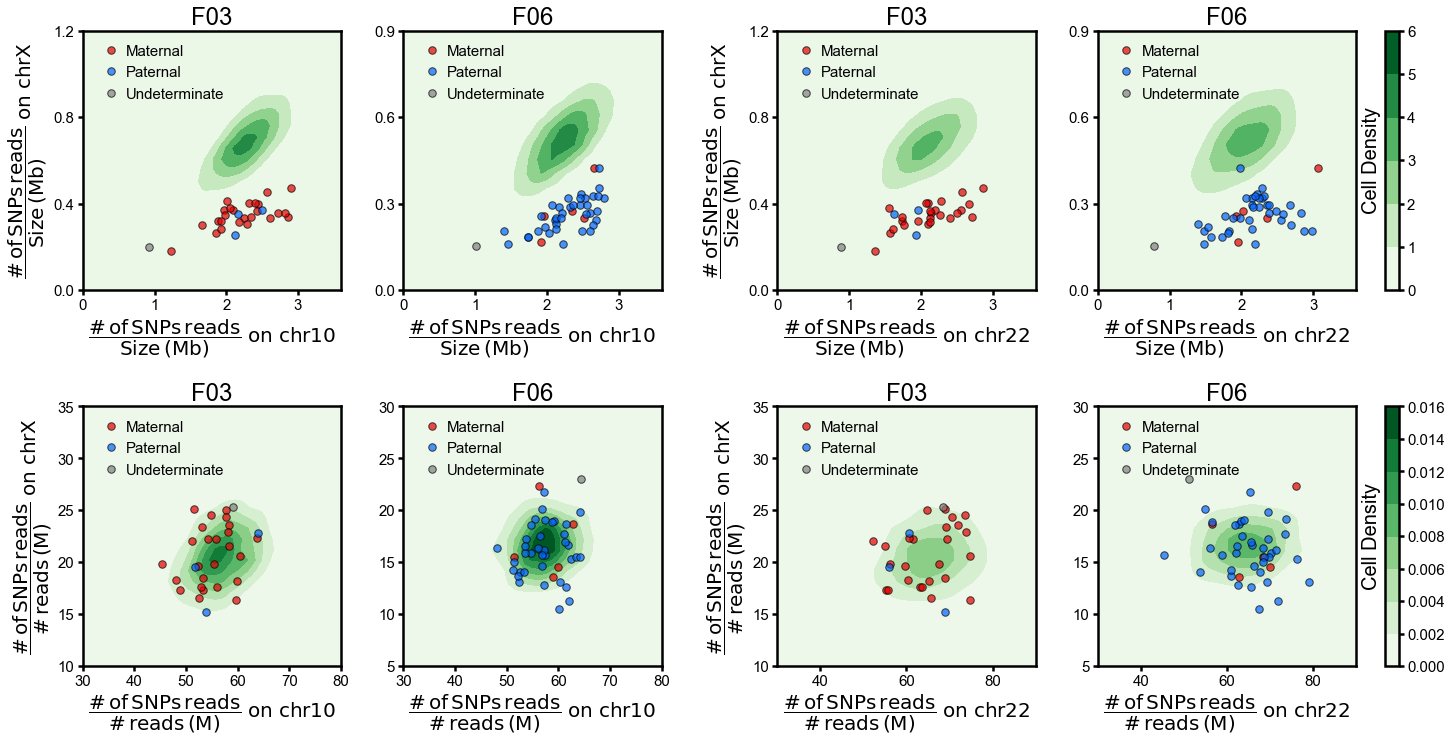

In [36]:
width_a4f = 1.15
hight_a4f = 0.4

fig = plt.figure(figsize=(a4f*width_a4f*8.27,a4f*hight_a4f*11.69))
# gs  = mpl.gridspec.GridSpec(nrows=16, ncols=24, figure=fig)
gs  = mpl.gridspec.GridSpec(nrows=12, ncols=25, figure=fig)

ax1 = fig.add_subplot( gs[ 0:5,  0:5 ] )
ax2 = fig.add_subplot( gs[ 0:5,  6:11 ] )
ax3 = fig.add_subplot( gs[ 0:5,  13:18 ] )
ax4 = fig.add_subplot( gs[ 0:5,  19:24 ] )

cs1, cs2 = kde_plot_chrX('chr10', ax1, ax2, tag='size')
cs3, cs4 = kde_plot_chrX('chr22', ax3, ax4, tag='size')
# kde_plot_chrX('chr21', ax3, ax4, tag='size')

ax2.set_ylim(0.0,0.9)
ax2.set_yticks( np.arange(0,1,0.3) )
ax4.set_ylim(0.0,0.9)
ax4.set_yticks( np.arange(0,1,0.3) )

ax5 = fig.add_subplot( gs[ 7:12,  0:5 ] )
ax6 = fig.add_subplot( gs[ 7:12,  6:11 ] )
ax7 = fig.add_subplot( gs[ 7:12,  13:18 ] )
ax8 = fig.add_subplot( gs[ 7:12,  19:24 ] )

cs5, cs6 = kde_plot_chrX('chr10', ax5, ax6, tag='reads')
cs7, cs8 = kde_plot_chrX('chr22', ax7, ax8, tag='reads')
# kde_plot_chrX('chr21', ax7, ax8, tag='reads')

ax7.set_xlim(30,90)
ax8.set_xlim(30,90)

ax_for_cs1 = fig.add_subplot( gs[ 0:5,   24: ] )
ax_for_cs2 = fig.add_subplot( gs[ 7:12,  24: ] )

# css = [cs1, cs2, cs3, cs4, cs5, cs6, cs7, cs8]
# axs = [ax_for_cs1, ax_for_cs2, ax_for_cs3, ax_for_cs4, ax_for_cs5, ax_for_cs6, ax_for_cs7, ax_for_cs8]
# lvs = [np.arange(0,7), np.arange(0,0.018,0.002)]

m = plt.cm.ScalarMappable(cmap='Greens')
m.set_array(cs1.get_array())
ax_for_cs1.axis('off')
inset_ax = inset_axes(
    ax_for_cs1,
    loc='right',
    height="100%", # set height
    width="30%", # and width
)
plt.colorbar(m, cax=inset_ax, boundaries=cs1.get_array())
inset_ax.tick_params(length=5, labelsize=smallsize)
inset_ax.set_ylabel('Cell Density', fontsize=midsize)
inset_ax.yaxis.set_label_position('left')

m = plt.cm.ScalarMappable(cmap='Greens')
m.set_array(cs5.get_array())
ax_for_cs2.axis('off')
inset_ax = inset_axes(
    ax_for_cs2,
    loc='right',
    height="100%", # set height
    width="30%", # and width
)
plt.colorbar(m, cax=inset_ax, boundaries=cs5.get_array())
inset_ax.tick_params(length=5, labelsize=smallsize)
inset_ax.set_ylabel('Cell Density', fontsize=midsize)
inset_ax.yaxis.set_label_position('left')

plt.show()

fig.savefig('A4_SI_kde.pdf', frameon=False, transparent=True, bbox_inches='tight')

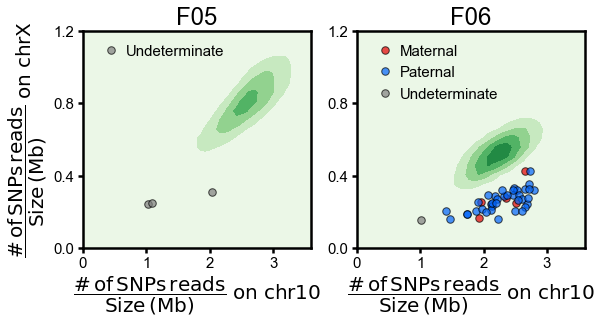

In [43]:
fig, axs = plt.subplots(ncols=2, figsize=(9,4))
ax1 = axs[0]
ax2 = axs[1]

chroms = 'chr10'

tag = 'size'
# tag = 'reads'

if tag == 'size':
    fig_df = snp_per_base

    xi, yi = np.mgrid[
        0 : 5 : 100*1j, 
        0 : 5 : 100*1j
    ]
#         x_label = r'$\dfrac{{\mathrm{{{}\,SNPs\,on\,{}}}}}{{\mathrm{{Size\,of\,{}}}}}$'.format('\#',chroms,chroms)
#         y_label = r'$\dfrac{{\mathrm{{{}\,SNPs\,on\,{}}}}}{{\mathrm{{Size\,of\,{}}}}}$'.format('\#','chrX','chrX')
    x_label = r'$\dfrac{{\mathrm{{{}\,of\,SNPs\,reads}}}}{{\mathrm{{Size\,(Mb)}}}}\;\mathrm{{on\;{}}}$'.format('\#',chroms)
    y_label = r'$\dfrac{{\mathrm{{{}\,of\,SNPs\,reads}}}}{{\mathrm{{Size\,(Mb)}}}}\;\mathrm{{on\;{}}}$'.format('\#','chrX')
    ax1.set_ylim(0,1.2)
    ax2.set_ylim(0,1.2)
    ax1.set_yticks([0,0.4,0.8,1.2])
    ax2.set_yticks([0,0.4,0.8,1.2])
    ax1.set_xlim(0,3.6)
    ax2.set_xlim(0,3.6)
    levels = np.arange(0,7)
    extend = 'neither'
    
elif tag == 'reads':
    fig_df = snp_per_reads

    xi, yi = np.mgrid[
        0 : 100 : 100*1j, 
        0 : 100 : 100*1j
    ]
#         x_label = r'$\dfrac{{\mathrm{{{}\,SNPs\,on\,{}}}}}{{\mathrm{{{}\,Reads\,on\,{}}}}}$'.format('\#',chroms,'\#',chroms)
#         y_label = r'$\dfrac{{\mathrm{{{}\,SNPs\,on\,{}}}}}{{\mathrm{{{}\,Reads\,on\,{}}}}}$'.format('\#','chrX','\#','chrX')
    x_label = r'$\dfrac{{\mathrm{{{}\,of\,SNPs\,reads}}}}{{\mathrm{{{}\,reads\,(M)}}}}\;\mathrm{{on\;{}}}$'.format('\#','\#',chroms)
    y_label = r'$\dfrac{{\mathrm{{{}\,of\,SNPs\,reads}}}}{{\mathrm{{{}\,reads\,(M)}}}}\;\mathrm{{on\;{}}}$'.format('\#','\#','chrX')
    ax1.set_xlim(30,80)
    ax2.set_xlim(30,80)
    ax1.set_ylim(10,35)
    ax2.set_ylim(5,30)
    levels = np.arange(0,0.018,0.002)
    extend = 'max'
else:
    pass

k_XXX = gaussian_kde( fig_df.loc[ fig_df.index[fig_df.index.str.contains('XXX')],  [chroms,'chrX']].T )
k_XXX   = gaussian_kde( fig_df.loc[ fig_df.index[fig_df.index.str.contains('XXX')  ],  [chroms,'chrX']].T )
k_XXX  = gaussian_kde( fig_df.loc[ fig_df.index[fig_df.index.str.contains('XXX')  ], [chroms,'chrX']].T )


z_XXX = k_XXX( np.vstack([xi.flatten(), yi.flatten()]) )
z_XXX   = k_XXX(   np.vstack([xi.flatten(), yi.flatten()]) )
z_XXX  = k_XXX(   np.vstack([xi.flatten(), yi.flatten()]) )

# cs1 = ax1.contourf(xi, yi, z_XXX.reshape(xi.shape), levels=levels, cmap='Greens', zorder=0, extend=extend)
cs1 = ax1.contourf(xi, yi, z_XXX.reshape(xi.shape), levels=levels, cmap='Greens', zorder=0, extend=extend)
cs2 = ax2.contourf(xi, yi, z_XXX.reshape(xi.shape), levels=levels,   cmap='Greens', zorder=0, extend=extend)

XXX_x_cells = cnv_frac_df.query('Space=="chrX" & cnvTag=="Loss" & chrom_fraction>=95 & Sample=="XXX"')['Cell'].unique()
ax1.plot(
    fig_df.loc[XXX_x_cells, chroms], 
    fig_df.loc[XXX_x_cells, 'chrX'], 
    '.', ms=15, alpha=0.7, markeredgecolor='k', color='gray', label='Undeterminate'
)

# ax1.plot(
#     fig_df.loc[XXX_pie_df.query('pA==True').index, chroms], 
#     fig_df.loc[XXX_pie_df.query('pA==True').index, 'chrX'], 
#     '.', ms=15, alpha=0.7, markeredgecolor='k', color=two_colors[0], label='Maternal'
# )
# ax1.plot(
#     fig_df.loc[XXX_pie_df.query('pB==True').index, chroms], 
#     fig_df.loc[XXX_pie_df.query('pB==True').index, 'chrX'], 
#     '.', ms=15, alpha=0.7, markeredgecolor='k', color=two_colors[1], label='Paternal'
# )

# ax1.plot(
#     fig_df.loc[XXX_pie_df.query('~(pA or pB)').index, chroms], 
#     fig_df.loc[XXX_pie_df.query('~(pA or pB)').index, 'chrX'], 
#     '.', ms=15, alpha=0.7, markeredgecolor='k', color='gray', label='Undeterminate'
# )

ax2.plot(
    fig_df.loc[XXX_pie_df.query('pA==True').index, chroms], 
    fig_df.loc[XXX_pie_df.query('pA==True').index, 'chrX'], 
    '.', ms=15, alpha=0.7, markeredgecolor='k', color=two_colors[0], label='Maternal'
)
ax2.plot(
    fig_df.loc[XXX_pie_df.query('pB==True').index, chroms], 
    fig_df.loc[XXX_pie_df.query('pB==True').index, 'chrX'], 
    '.', ms=15, alpha=0.7, markeredgecolor='k', color=two_colors[1], label='Paternal'
)
ax2.plot(
    fig_df.loc[XXX_pie_df.query('~(pA or pB)').index, chroms], 
    fig_df.loc[XXX_pie_df.query('~(pA or pB)').index, 'chrX'], 
    '.', ms=15, alpha=0.7, markeredgecolor='k', color='gray', label='Undeterminate'
)

ax1.set_ylabel(y_label, fontsize=midsize)
ax2.set_ylabel('')

ax1.set_xlabel(x_label, fontsize=midsize)
ax2.set_xlabel(x_label, fontsize=midsize)

ax1.tick_params(length=5, labelsize=smallsize)
ax2.tick_params(length=5, labelsize=smallsize)

ax1.set_title(xlsx_tab.set_index('SAMPLE').loc['XXX','CODE'], fontsize=hugesize)
ax2.set_title(xlsx_tab.set_index('SAMPLE').loc['XXX',  'CODE'],fontsize=hugesize)

ax1.legend(loc='upper left', prop={'size':smallsize}, handletextpad=0, frameon=False,)
ax2.legend(loc='upper left', prop={'size':smallsize}, handletextpad=0, frameon=False,)

plt.show()
